<a href="https://colab.research.google.com/github/GishB/Deep-Learning-project/blob/main/MLP_model_binary_classification_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all important libraries

In [2]:
#Import all libraries which is required for project tasks
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
import PIL

from PIL import Image
import torchvision
from torchvision import datasets, transforms, utils
from torchvision.datasets import ImageFolder
import os

# Augumentation NORMAL chest X-rays. Increase number of NORMAL chest X-rays images from 1500 to 4622 pictures. Run just once and save in directory!

In [3]:
# path_to_folder = '/Users/peterbkh/miniconda3/deep-learning-liege/NORMAL'
# new_folder = 'test'



# for i in os.listdir(path_to_folder):
#   img_path = path_to_folder + '/' + i
#   print(i)
#   im = Image.open(img_path)
#   im = im.convert("RGB")

#   vertical_img = im.transpose(method=Image.FLIP_TOP_BOTTOM)
#   vertical_img.save(new_folder + "/vertical_" + i)

#   hor_img = im.transpose(method=Image.FLIP_LEFT_RIGHT)
#   hor_img.save(new_folder + "/horisontal_" + i)

# Import X-ray chest images from google drive directory. Here we have 4622 NORMAL and 4273 PNEUMONIA images

In [4]:
root_dir = '/content/drive/MyDrive/DATASET_FINAL/images'
csv_dir = '/content/drive/MyDrive/DATASET_FINAL/x_ray_new.csv'

# Dataloader

In [5]:
class XRayChestDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
 #   image = io.imread(img_path)
    image = Image.open(img_path).convert('RGB')
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [6]:
#transform rule for data
preprocess = transforms.Compose([
  #do size 64 to 64 to make computations faster for computer
  transforms.Resize(size=(64, 64)),
  #do transform.ToTensor for data, because it is important for PyTorch
  transforms.ToTensor(),
  #add normalize for pretrained models like VGG16, AlexNet
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  ])

#Dataset which we are gonna working with
dataset = XRayChestDataset(csv_file = csv_dir, root_dir = root_dir, transform = preprocess)

#split data to 70/20/10 sets
number_of_images = len(dataset)

number_of_images_train = int(number_of_images*0.7)
number_of_images_test = int(number_of_images*0.2)
number_of_images_valid = number_of_images - number_of_images_train - number_of_images_test

train_set, test_set, valid_set = torch.utils.data.random_split(dataset, [number_of_images_train,
                                                                         number_of_images_test,
                                                                         number_of_images_valid])

In [7]:
#hint: DO NOT USE JUPYNER NOTEBOOK! IT DOSENT SUPPORT multiprocess. There is a lag when num_workers > 0!
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, num_workers=2)
valid_loader = data.DataLoader(dataset=valid_set, batch_size=1, shuffle=False, num_workers=2) 


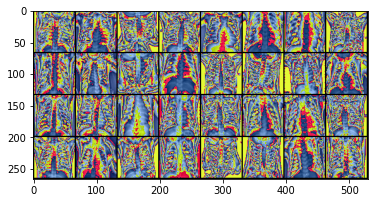

NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA


In [8]:
classes = ('NORMAL', 'PNEUMONIA')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()


images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

#Should working about 1 minute before it shows images and labels

# Import models

In [9]:
#Define a structure of MLP model which used as baseline model
model_MLP = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12288, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
)

# #Define a structure of CNN model which used as baseline model
# model_CNN = nn.Sequential(
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         nn.Conv2d(1, 6, 3),
#         nn.ReLU(),
#         nn.max_pool2d((2,2)),
#         nn.Conv2d(6, 16, 3),
#         nn.ReLU(),
#         nn.max_pool2d(2),
#         torch.flatten(1),
#         # an affine operation: y = Wx + b
#         nn.Linear(16 * 3 * 3, 120),  # 5*5 from image dimension
#         nn.ReLU(),
#         nn.Linear(120, 84),
#         nn.ReLU(),
#         nn.Linear(84, 10)
# )

# #Define a structure of VGG16
# # model_VGG16 = nn.Sequential(
# # )
# model_VGG16 = torchvision.models.vgg16(pretrained=True)

# #Define a structure of alexnet
# # model_alexnet = nn.Sequential(
# # )
# model_AlexNet = torchvision.models.alexnet(pretrained=True)

# #Define a structure of U-net
# # model_U-net = nn.Sequential(
# # )
# model_Unet = torchvision.models.unet(pretrained=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_MLP.to(device)
# model_CNN.to(device)
# model_VGG16.to(device)
# model_AlexNet.to(device)
# model_Unet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_MLP.parameters(), lr = 0.001)

# Train models block

In [11]:
def train(num_epochs):

    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        for x, y in train_loader:
            x = x.to(device) # your code !
            y = y.to(device) # your code !
            
            pred = model_MLP(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0

            # true_positive = 0
            # true_negative = 0
            # false_negative = 0
            # false_positive = 0
            for x, y in test_loader:
                x = x.to(device) # your code !!
                y = y.to(device) # your code !!
                
                pred = model_MLP(x)
                loss = criterion(pred, y)
                test_losses.append(loss)
                
                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

                # #Some more statistics
                # true_positive = true_positive + (y_pred == y and y == 1).sum()
                # true_negative = true_negative + (y_pred != y and y == 1).sum()
                # false_positive = false_positive + (y_pred == y and y == 0).sum()
                # false_negative = false_negative + (y_pred != y and y == 0).sum()

            accuracy = correct / len(test_set)

        
        train_losses = torch.as_tensor(train_losses) #UPDATE5.1 (avoid copy), it is important  for .append
        test_losses = torch.as_tensor(test_losses) #UPDATE5.1 (avoid copy), it is important for .append
        
        mean_test_loss = torch.mean(test_losses) #UPDATE5.2 TO CONTROL PRINT
        mean_train_loss = torch.mean(train_losses) #UPDATE5.2 TO CONTROL PRINT
        
        train_avg_loss.append(mean_train_loss) # your code UPDATE5
        test_avg_loss.append(mean_test_loss) # your code UPDATE5
        test_accuracy.append(accuracy) # your code UPDATE5
        
        print(f'This is {i} epoch. \n Test loss = {mean_test_loss}, Train loss = {mean_train_loss}, Accuracy = {accuracy}')
    test_accuracy = torch.tensor(test_accuracy)
    return train_avg_loss, test_avg_loss, test_accuracy  # UPDATE4

In [74]:
def sigmoid_output_transform(output):
  y_pred = torch.sigmoid(output)
  return y_pred


def roc_auc_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor) -> float:
    from sklearn.metrics import roc_auc_score

    y_true = y_targets.cpu().numpy()
    y_pred = y_preds.cpu().numpy()
    return roc_auc_score(y_true, y_pred)

def roc_auc_curve_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor):
    from sklearn.metrics import roc_curve

    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
    return roc_curve(y_true, y_pred)

def validate_model(valid_loader):

  true_positive = 0
  true_negative = 0
  false_negative = 0
  false_positive = 0


  
  list_pred = []
  list_data_1 = []
  for x, y in valid_loader:
    x = x.to(device) # your code !!
    y = y.to(device) # your code !!
                    
    pred = model_MLP(x)
    # loss = criterion(pred, y)
    # test_losses.append(loss)
              
    y_pred = pred.argmax(dim=-1)
    y_pred_test = sigmoid_output_transform(y_pred)
    list_pred.append(y_pred_test)    
    list_data_1.append(y)



                    #Some more statistics
    if y_pred == y:
      if y == 1:
        true_positive = true_positive + (y == 1).sum()
      elif y == 0:
        true_negative = true_negative + (y == 0).sum()
    elif y_pred != y:
      if y == 1:
        false_positive = false_positive + (y == 1).sum()
      elif y == 0:
        false_negative = false_negative + (y == 0).sum()


  precision = true_positive / ( true_positive + false_positive )
  recall = true_positive / ( true_positive + false_negative )
  F1_score = precision*recall*2/(precision + recall)
  print(f'F1 = {F1_score}, Precision = {precision}, Recall = {recall}, True positive = {true_positive}, True negative = {true_negative}')
  print(f'False positive = {false_positive}, False negative = {false_negative}')

############################################################################################################
#Try to use ROC AUC
  list_pred = torch.tensor(list_pred)
  list_data_1 = torch.tensor(list_data_1)

  auc = roc_auc_compute_fn(list_pred, list_data_1)
  curve_test = roc_auc_curve_compute_fn(list_pred, list_data_1)

#The ``output_transform`` arg of the metric can be used to perform a sigmoid on the ``y_pred``.
  plt.plot(curve_test[0], curve_test[1], color='darkorange',
          label='ROC curve (area = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC/AUC curve')
  plt.legend(loc="lower right")
  plt.show()
############################################################################################################
  return F1_score, precision, recall, true_positive, true_negative, false_positive, false_negative, auc, curve_test

In [13]:
train_avg_loss, test_avg_loss, test_accuracy = train(7)

This is 0 epoch. 
 Test loss = 0.15279987454414368, Train loss = 0.5544155240058899, Accuracy = 0.9429211020469666
This is 1 epoch. 
 Test loss = 0.17589695751667023, Train loss = 0.1266133189201355, Accuracy = 0.935086727142334
This is 2 epoch. 
 Test loss = 0.12502293288707733, Train loss = 0.11236046999692917, Accuracy = 0.9496362805366516
This is 3 epoch. 
 Test loss = 0.14540190994739532, Train loss = 0.1177324652671814, Accuracy = 0.9423614740371704
This is 4 epoch. 
 Test loss = 0.19156038761138916, Train loss = 0.10843057930469513, Accuracy = 0.9289311766624451
This is 5 epoch. 
 Test loss = 0.12801674008369446, Train loss = 0.10242258012294769, Accuracy = 0.9557918310165405
This is 6 epoch. 
 Test loss = 0.11412574350833893, Train loss = 0.08480333536863327, Accuracy = 0.954672634601593


F1 = 0.955503523349762, Precision = 0.9577465057373047, Recall = 0.9532710313796997, True positive = 408, True negative = 448
False positive = 18, False negative = 20


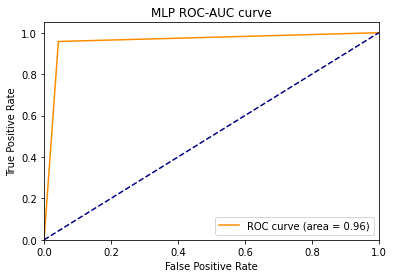

In [75]:
valid_test = validate_model(valid_loader)

# Plot models results

Text(0, 0.5, 'Accuracy percent')

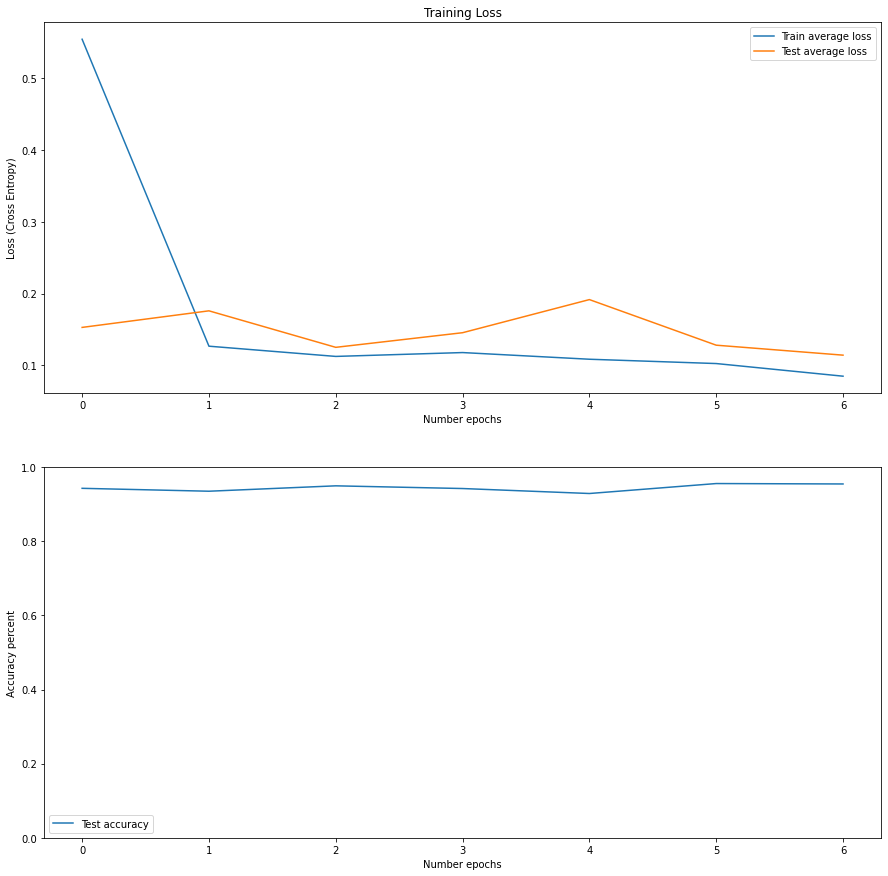

In [15]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
ax[0].set_title('Training Loss')
ax[0].plot(train_avg_loss, label='Train average loss')
ax[0].plot(test_avg_loss, label='Test average loss')
ax[1].plot(test_accuracy, label='Test accuracy')
ax[1].set_ylim([0, 1])
ax[0].legend()
ax[0].set_xlabel('Number epochs')
ax[0].set_ylabel('Loss (Cross Entropy)')
ax[1].legend()
ax[1].set_xlabel('Number epochs')
ax[1].set_ylabel('Accuracy percent')